# Add GSAA reference data to patches

This script adds GSAA reference data to each EOPatch in vector and raster format.

The following features are added to eopatches:

 * original vector data
 * raster mask from pixelated vector data, 10m buffer
 * boundary mask (buffered raster minus raster pixelated)
 * normalised distance transform

In [1]:
from abc import abstractmethod
import os
import boto3
import fs
from fs_s3fs import S3FS

import pyproj
from shapely.ops import transform

import psycopg2

from datetime import datetime, timedelta
import dateutil
import rasterio
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from typing import List, Union, Tuple, Optional

from skimage.morphology import binary_dilation, disk
from skimage.measure import label
from scipy.ndimage import distance_transform_edt

from sentinelhub import CRS, BBox

from eolearn.core import FeatureType, EOPatch, EOTask, EOWorkflow, LinearWorkflow, LoadTask, SaveTask, OverwritePermission, EOExecutor
from eolearn.geometry import VectorToRaster

In [2]:
# plotting utils

def get_extent(eopatch: EOPatch) -> Tuple[float, float, float, float]:
    """
    Calculate the extent (bounds) of the patch.

    Parameters
    ----------
    eopatch: EOPatch for which the extent is calculated.

    Returns The list of EOPatch bounds (min_x, max_x, min_y, max_y)
    -------
    """
    return eopatch.bbox.min_x, eopatch.bbox.max_x, eopatch.bbox.min_y, eopatch.bbox.max_y


def draw_true_color(ax: plt.axes, eopatch: EOPatch, time_idx: Union[List[int], int],
                    feature_name='BANDS-S2-L2A',
                    bands: Tuple[int] = (3, 2, 1),
                    factor: int = 3.5,
                    grid: bool = True):
    """
    Visualization of the bands in the EOPatch.
    Parameters
    ----------
    ax: Axis on which to plot
    eopatch: EOPatch to visualize.
    time_idx: Single timestamp or multiple timestamps.
    feature_name: Name of the feature to visualize.
    bands: Order of the bands.
    factor: Rescaling factor to
    grid: Show grid on visualization

    Returns None
    -------

    """
    def visualize_single_idx(axis, ts):
        axis.imshow(np.clip(eopatch.data[feature_name][ts][..., bands] * factor, 0, 1), extent=get_extent(eopatch))
        if grid:
            axis.grid()
            axis.set_title(f'{feature_name} {eopatch.timestamp[time_idx]}')

    if isinstance(time_idx, int):
        time_idx = [time_idx]
    if len(time_idx) == 1:
        visualize_single_idx(ax, time_idx[0])
    else:
        for i, tidx in enumerate(time_idx):
            visualize_single_idx(ax[i], tidx)

            
def draw_outline(o, lw, foreground='black'):
    """
    Adds outline to the matplotlib patch.

    Parameters
    ----------
    o:
    lw: Linewidth
    foreground

    Returns
    -------
    """
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground=foreground), patheffects.Normal()])


def draw_poly(ax, poly: Union[Polygon, MultiPolygon], color: str = 'r', lw: int = 2, outline: bool = True):
    """
    Draws a polygon or multipolygon onto an axes.

    Parameters
    ----------
    ax: Matplotlib Axes on which to plot on
    poly: Polygon or Multipolygons to plot
    color: Color of the plotted polygon
    lw: Line width of the plot
    outline: Should the polygon be outlined

    Returns None
    -------

    """
    if isinstance(poly, MultiPolygon):
        polys = list(poly)
    else:
        polys = [poly]
    for poly in polys:
        if poly is None:
            logger.warning("One of the polygons is None.")
            break
        if poly.exterior is None:
            logger.warning("One of the polygons has not exterior.")
            break

        x, y = poly.exterior.coords.xy
        xy = np.moveaxis(np.array([x, y]), 0, -1)
        patch = ax.add_patch(patches.Polygon(xy, closed=True, edgecolor=color, fill=False, lw=lw))

    if outline:
        draw_outline(patch, 4)


def draw_bbox(ax, eopatch: EOPatch, color: str = 'r', lw: int = 2, outline: bool = True):
    """
    Plots an EOPatch bounding box onto a matplotlib axes.
    Parameters
    ----------
    ax: Matplotlib axes on which to plot.
    eopatch: EOPatch with BBOx
    color: Color of the BBOX plot.
    lw: Line width.
    outline: Should the plot be additionally outlined.

    Returns None
    -------

    """
    bbox_poly = eopatch.bbox.get_polygon()
    draw_poly(ax, Polygon(bbox_poly), color=color, lw=lw, outline=outline)

    
def draw_mask(ax, eopatch: EOPatch, time_idx: Union[List[int], int, None], feature_name: str, grid: bool = True,
              vmin: int = 0, vmax: int = 1, alpha: float = 1.0):
    """
    Draws an EOPatch mask or mask_timeless feature.
    Parameters
    ----------
    ax: Matplotlib axes on which to plot on
    eopatch: EOPatch for which to plot the mask:
    time_idx: Time index of the mask. If int, single time index of the mask feature, if List[int] multiple masks for
    each time index. If None, plot mask_timeless.
    feature_name: Name of the feature to plot.
    grid: Show grid on plot:
    vmin: Minimum value (for mask visualization)
    vmax: Maximum value (for mask visualization)
    alpha: Transparency of the mask
    Returns
    -------

    """

    def _show_single_ts(axis, msk, ts):
        axis.imshow(msk, extent=get_extent(eopatch), vmin=vmin, vmax=vmax, alpha=alpha)
        if grid:
            axis.grid()
        title = f'{feature_name} {eopatch.timestamp[ts]}' if ts is not None else f'{feature_name}'
        axis.set_title(title)

    if time_idx is None:
        mask = eopatch.mask_timeless[feature_name].squeeze()
        _show_single_ts(ax, mask, time_idx)
    elif isinstance(time_idx, int):
        mask = eopatch.mask[feature_name][time_idx].squeeze()
        _show_single_ts(ax, mask, time_idx)
    elif isinstance(time_idx, list):
        for i, tidx in enumerate(time_idx):
            mask = eopatch.mask[feature_name][tidx].squeeze()
            _show_single_ts(ax[i], mask, tidx)


def draw_vector_timeless(ax, eopatch: EOPatch, vector_name: str, color: str = 'b', alpha: int = 0.5):
    """
    Draws all polygons from EOPatch' timeless vector geopandas data frame.

    Parameters
    ----------
    ax: Axes on which to plot on
    eopatch: EOPatch from which to plot the vector_timeless features
    vector_name: Name of the vector_timeless feature
    color: Color of the polygons on the plot
    alpha: Transparency of the polygon on the plot.

    Returns
    -------

    """
    eopatch.vector_timeless[vector_name].plot(ax=ax, color=color, alpha=alpha)


Set up S3FS for `bucket-name`

In [3]:
os.environ["CURL_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt"

In [4]:
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""
REGION_NAME = "eu-central-1"

Load tile correspondence between batch processes

In [5]:
tile_correspondence = gpd.read_file('../../input-data/tiles-correspondence.geojson')
tile_correspondence.head()

id_left                        requestId_left  \
0  1702790  964d90b7-41a7-4025-a392-140ae5236bf5   
1  1702791  964d90b7-41a7-4025-a392-140ae5236bf5   
2  1702792  964d90b7-41a7-4025-a392-140ae5236bf5   
3  1702793  964d90b7-41a7-4025-a392-140ae5236bf5   
4  1702794  964d90b7-41a7-4025-a392-140ae5236bf5   

                                        geojson_left status_left   cost_left  \
0  {'type': 'Polygon', 'crs': {'type': 'name', 'p...   PROCESSED  139.872230   
1  {'type': 'Polygon', 'crs': {'type': 'name', 'p...   PROCESSED  133.514401   
2  {'type': 'Polygon', 'crs': {'type': 'name', 'p...   PROCESSED  127.156572   
3  {'type': 'Polygon', 'crs': {'type': 'name', 'p...   PROCESSED  127.156572   
4  {'type': 'Polygon', 'crs': {'type': 'name', 'p...   PROCESSED  127.156572   

   index_right  id_right                       requestId_right  \
0            0   1703758  ab0442c1-6c27-4bec-a798-8953ad955698   
1            1   1703759  ab0442c1-6c27-4bec-a798-8953ad955698   
2            2   1703760  ab0442c1-6c27-4bec-a798-8953ad955698   
3            3   1703761  ab0442c1-6c27-4bec-a798-8953ad955698   
4            4   1703762  ab0442c1-6c27-4bec-a798-8953ad955698   

                                       geojson_right status_right  cost_right  \
0  {'type': 'Polygon', 'crs': {'type': 'name', 'p...    PROCESSED  203.450516   
1  {'type': 'Polygon', 'crs': {'type': 'name', 'p...    PROCESSED  193.913773   
2  {'type': 'Polygon', 'crs': {'type': 'name', 'p...    PROCESSED  184.377030   
3  {'type': 'Polygon', 'crs': {'type': 'name', 'p...    PROCESSED  184.377030   
4  {'type': 'Polygon', 'crs': {'type': 'name', 'p...    PROCESSED  184.377030   

   eopatch_name                                           geometry  
0  eopatch-0000  POLYGON ((20.68052 55.85511, 20.67978 55.94496...  
1  eopatch-0001  POLYGON ((20.68125 55.76526, 20.68052 55.85511...  
2  eopatch-0002  POLYGON ((20.68198 55.67541, 20.68125 55.76526...  
3  eopatch-0003  POLYGON ((20.68343 55.49570, 20.68271 55.58555...  
4  eopatch-0004  POLYGON ((20.68415 55.40584, 20.68343 55.49570...

In [67]:
PATCHES_PATH = 'data/Lithuania/eopatches/2019'

Read eopatch list

In [8]:
eopatches_list = tile_correspondence.eopatch_name.values

Util tasks

In [23]:
class DB2Vector(EOTask):
    """
    Reads vectors to EOPatch from a local postgre db.
    """

    def __init__(self, vector_output_feature):
        self.database=""
        self.user = ""
        self.password = ""
        self.host = ""
        self.port = ""
        self.crs = CRS.WGS84.pyproj_crs()
        self.out_vector = next(self._parse_features(vector_output_feature)())

    def execute(self, eopatch):
        utm_crs = eopatch.bbox.crs.pyproj_crs()
        project = pyproj.Transformer.from_proj(utm_crs, self.crs)
        
        query_bbox = transform(project.transform, eopatch.bbox.geometry)

        spatial_query = 'select * from gsaa where ST_Intersects(ST_GeomFromText((%s), (%s)), geom);'
        parameters = (query_bbox.wkt, self.crs.to_epsg())

        with psycopg2.connect(database=self.database, user=self.user, password=self.password, 
                              host=self.host, port=self.port) as con:
            df = gpd.GeoDataFrame.from_postgis(spatial_query, con, geom_col='geom', params=parameters)
            df = df.to_crs(utm_crs).rename(columns={'geom':'geometry'}).set_geometry('geometry')
        
        eopatch[self.out_vector] = df

        return eopatch
    
    
class Extent2Boundary(EOTask):
    """
    Adds boundary mask from extent mask using binary dilation
    """
    def __init__(self, extent_feature, boundary_feature, structure=None):
        self.extent_feature = next(self._parse_features(extent_feature)())
        self.boundary_feature = next(self._parse_features(boundary_feature)())
        self.structure = structure
        
    def execute(self, eopatch):
        extent_mask = eopatch[self.extent_feature].squeeze(axis=-1)
        boundary_mask = binary_dilation(extent_mask, selem=self.structure) - extent_mask
        eopatch[self.boundary_feature] = boundary_mask[..., np.newaxis]
        
        return eopatch
    
    
class Extent2Distance(EOTask):
    """
    Adds boundary mask from extent mask using binary dilation
    """
    def __init__(self, extent_feature, distance_feature, normalize=True):
        self.extent_feature = next(self._parse_features(extent_feature)())
        self.distance_feature = next(self._parse_features(distance_feature)())
        self.normalize = normalize
        
    def execute(self, eopatch):
        extent_mask = eopatch[self.extent_feature].squeeze(axis=-1)
        
        distance = distance_transform_edt(extent_mask)
        
        if not self.normalize:
        
            eopatch[self.distance_feature] = distance[..., np.newaxis]

            return eopatch
        
        conn_comp = label(extent_mask, background=0)
        unique_comp = np.unique(conn_comp)
        normalised = np.zeros(distance.shape, dtype=np.float32)
        
        for uc in unique_comp:
            if uc != 0:
                conn_comp_mask = conn_comp==uc
                normalised[conn_comp_mask] += distance[conn_comp_mask]/np.max(distance[conn_comp_mask])
            
        eopatch[self.distance_feature] = normalised[..., np.newaxis]

        return eopatch
        

In [10]:
vector_feature = (FeatureType.VECTOR_TIMELESS, 'GSAA_ORIGINAL')
extent_feature = (FeatureType.MASK_TIMELESS, 'EXTENT')
boundary_feature = (FeatureType.MASK_TIMELESS, 'BOUNDARY')
distance_feature = (FeatureType.DATA_TIMELESS, 'DISTANCE')

In [24]:
# load patch
load_task = LoadTask(path=f's3://bucket-name/{PATCHES_PATH}')
# add original vectors to patch
vec2vec = DB2Vector(vector_feature)
# get extent mask from vector
vec2ras = VectorToRaster(vector_feature, 
                         extent_feature, 
                         values=1, raster_shape=(1000,1000), 
                         no_data_value=0, buffer=-10, write_to_existing=False)
# get boundary mask from extent mask
ras2bound = Extent2Boundary(extent_feature, 
                            boundary_feature,
                            structure=disk(2))
# get distance from extent mask
ras2dist = Extent2Distance(extent_feature, 
                           distance_feature, 
                           normalize=True)
# save new features
save_task = SaveTask(path=f's3://bucket-name/{PATCHES_PATH}',
                     features=[vector_feature, extent_feature, boundary_feature, distance_feature],
                     overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

Set up workflow

In [31]:
workflow = LinearWorkflow(load_task, vec2vec, vec2ras, ras2bound, ras2dist, save_task)

Try on a patch

In [13]:
result = workflow.execute({
    load_task: {'eopatch_folder': 'eopatch-0593'},
    save_task: {'eopatch_folder': 'eopatch-0593'}
    })

In [14]:
eop = list(result.values())[-1]

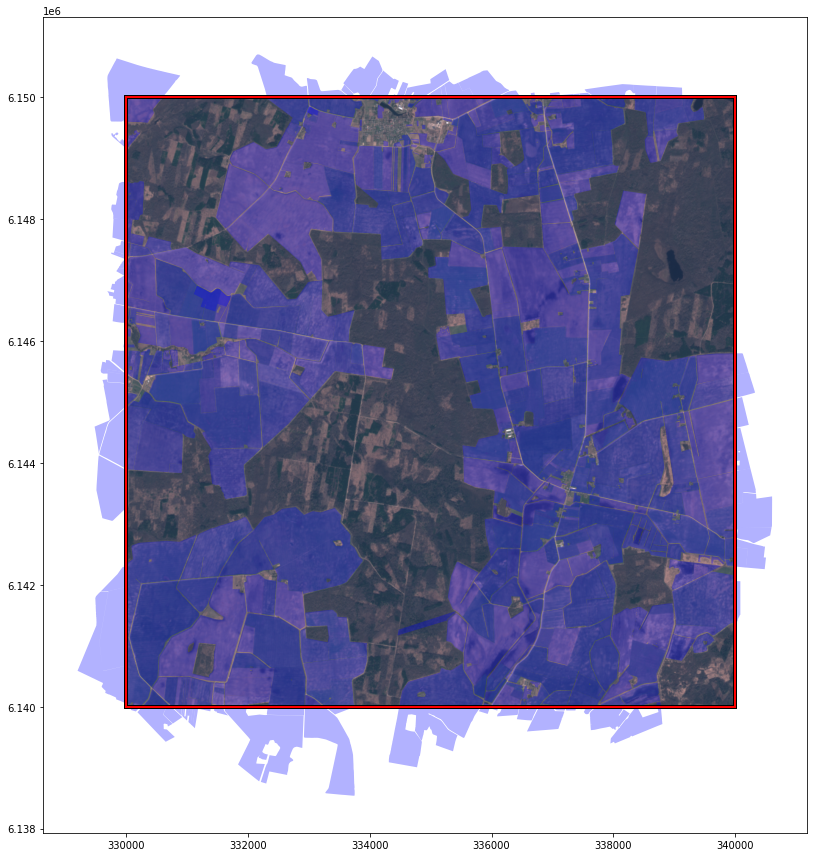

In [16]:
fig, ax = plt.subplots(figsize=(15, 15))
draw_true_color(ax, eop, time_idx=10, factor=3.5/10000, feature_name='BANDS', bands=(2, 1, 0), grid=False)
draw_bbox(ax, eop)
draw_vector_timeless(ax, eop, vector_name='GSAA_ORIGINAL', alpha=.3)

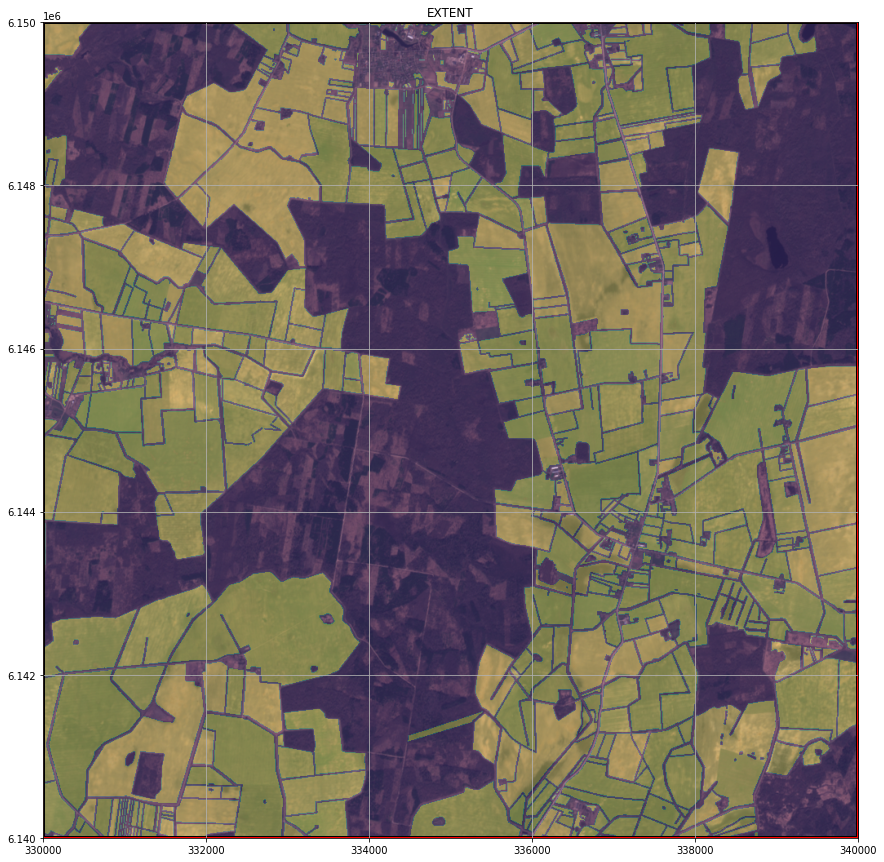

In [17]:
fig, ax = plt.subplots(figsize=(15, 15))
draw_true_color(ax, eop, time_idx=10, factor=3.5/10000, feature_name='BANDS', bands=(2, 1, 0), grid=False)
draw_bbox(ax, eop)
draw_mask(ax, eop, time_idx=None, feature_name='EXTENT', alpha=.3)

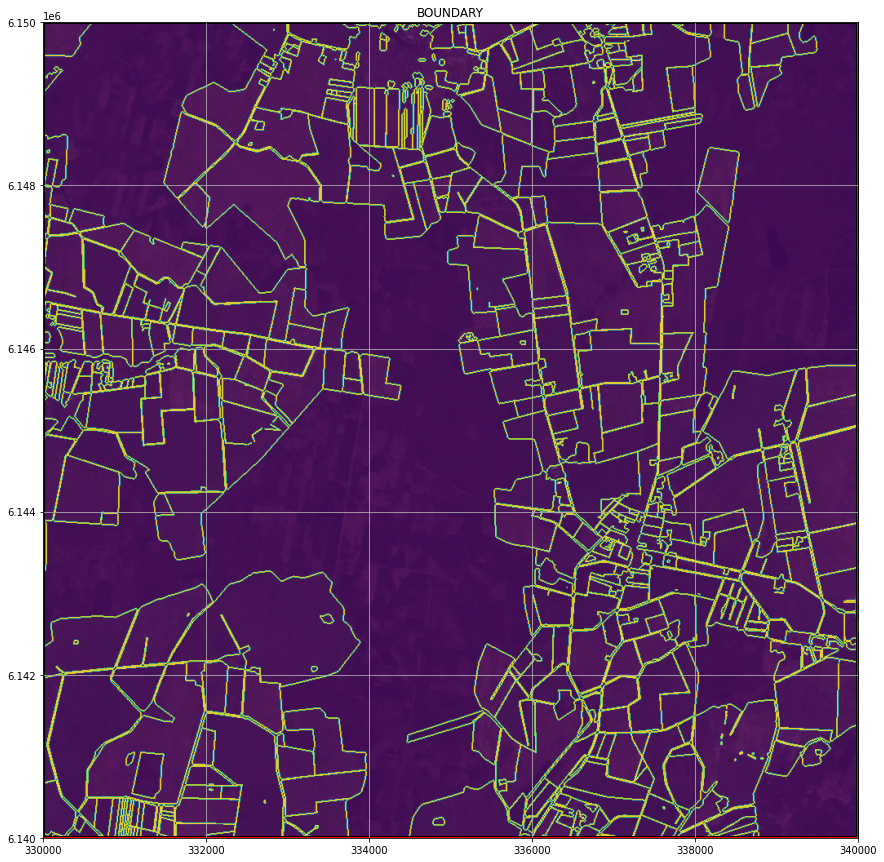

In [18]:
fig, ax = plt.subplots(figsize=(15, 15))
draw_true_color(ax, eop, time_idx=10, factor=3.5/10000, feature_name='BANDS', bands=(2, 1, 0), grid=False)
draw_bbox(ax, eop)
draw_mask(ax, eop, time_idx=None, feature_name='BOUNDARY', alpha=.8)

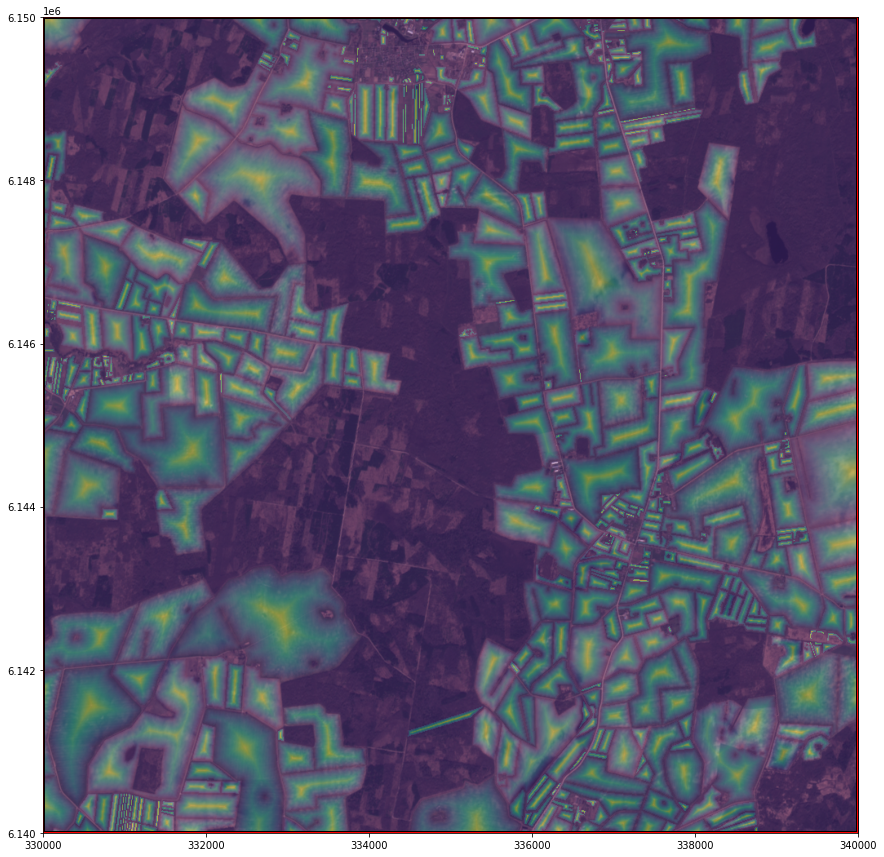

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))
draw_bbox(ax, eop)
draw_true_color(ax, eop, time_idx=10, factor=3.5/10000, feature_name='BANDS', bands=(2, 1, 0), grid=False)
ax.imshow(eop.data_timeless['DISTANCE'].squeeze(), extent=get_extent(eop), alpha=.4)

Build list of inputs for execution

In [32]:
exec_args = []

for eopatch_name in tqdm(eopatches_list, total=len(eopatches_list)):

    single_exec_dict = {}

    single_exec_dict[load_task] = dict(eopatch_folder=f'{eopatch_name}')

    single_exec_dict[save_task] = dict(eopatch_folder=f'{eopatch_name}')

    exec_args.append(single_exec_dict)


Run on all eopatches in parallel

In [21]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [37]:
MAX_WORKERS = 32

executor = EOExecutor(workflow, exec_args, save_logs=True, logs_folder='.')

executor.run(workers=MAX_WORKERS)

In [38]:
%matplotlib

executor.make_report()

print('Report was saved to location: {}'.format(executor.get_report_filename()))

Using matplotlib backend: agg
Report was saved to location: ./eoexecution-report-2020_06_03-09_13_04/report.html


In [41]:
failed = !grep failed -l /home/ubuntu/field-delineation/notebooks/eoexecution-report-2020_06_03-09_13_04/*log | awk '{system("grep eopatch_folder "$0)}' | awk -F "'" '{print $4}'

In [57]:
tiles = tile_correspondence[['eopatch_name','geometry']].copy()

In [58]:
len(tiles)

938

In [59]:
tiles['failed']=False
tiles.loc[tiles['eopatch_name'].isin(failed), ['failed']]=True

tiles.to_file('/home/ubuntu/processed.geojson', driver='GeoJSON') 

#tiles geojson is available at s3://bucket-name/data/Lithuania/03_execution_results.geojson

In [68]:
tiles.plot('failed', figsize=(15,15))